```

================================================================================

SECCIÓN 5: EVALUACIÓN E INTERPRETACIÓN
Tareas 18-20

Dataset: Resultados Pruebas Saber 11 - ICFES
Variable Objetivo: DESEMP_INGLES (A-, A1, A2, B1, B+)

================================================================================

OBJETIVOS DE ESTA SECCIÓN:

1. TAREA 18: Comparar resultados de aprendizaje supervisado vs no supervisado
2. TAREA 19: Implementar mejoras metodológicas avanzadas
3. TAREA 20: Realizar discusión crítica y conclusiones del proyecto

================================================================================
```

In [6]:
# ============================================
# CONFIGURACIÓN INICIAL E IMPORTACIONES
# ============================================

# Librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime

# Scikit-learn - Modelos y métricas
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, cohen_kappa_score,
    balanced_accuracy_score, roc_auc_score, roc_curve,
    adjusted_rand_score, normalized_mutual_info_score, v_measure_score,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Balanceo de clases
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA

# Configuración de visualizaciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("=" * 80)
print("SECCIÓN 5: EVALUACIÓN E INTERPRETACIÓN")
print("=" * 80)
print(f"Configuración completada - Random State: {RANDOM_STATE}")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

SECCIÓN 5: EVALUACIÓN E INTERPRETACIÓN
Configuración completada - Random State: 42
Fecha de ejecución: 2025-11-14 21:11:02


In [7]:
# ============================================
# CARGA DE DATOS Y MODELOS DE SECCIONES ANTERIORES
# ============================================

print("\nCargando datos y modelos de secciones anteriores...\n")

# Intentar cargar el dataset completo
try:
    # Primero intentar desde notebooks/
    if os.path.exists('../notebooks/dataset_saber11_reducido_estratificado.csv'):
        print("Cargando dataset CSV desde ../notebooks/...")
        df = pd.read_csv('../data/raw/dataset_saber11_reducido_estratificado.csv')
    elif os.path.exists('dataset_saber11_reducido_estratificado.csv'):
        print("Cargando dataset CSV desde directorio actual...")
        df = pd.read_csv('../data/raw/dataset_saber11_reducido_estratificado.csv')
    else:
        raise FileNotFoundError("Dataset no encontrado")
    
    print(f"✓ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    
    # Identificar la variable objetivo
    target_col = 'DESEMP_INGLES'
    if target_col not in df.columns:
        # Buscar columna similar
        target_candidates = [col for col in df.columns if 'INGLES' in col.upper()]
        if target_candidates:
            target_col = target_candidates[0]
        print(f"Usando variable objetivo: {target_col}")
    
    print(f"Distribución de clases en {target_col}:")
    print(df[target_col].value_counts().sort_index())
    
except Exception as e:
    print(f"⚠ Warning: No se pudo cargar el dataset completo: {e}")
    print("Se generarán datos sintéticos para demostración...\n")
    
    # Generar datos sintéticos
    np.random.seed(RANDOM_STATE)
    n_samples = 10000
    n_features = 15
    
    X = np.random.randn(n_samples, n_features)
    y = np.random.choice(['A-', 'A1', 'A2', 'B1', 'B+'], size=n_samples, 
                         p=[0.05, 0.15, 0.50, 0.25, 0.05])
    
    feature_names = [f'FEATURE_{i+1}' for i in range(n_features)]
    df = pd.DataFrame(X, columns=feature_names)
    df['DESEMP_INGLES'] = y
    target_col = 'DESEMP_INGLES'
    
    print(f"✓ Dataset sintético creado: {n_samples:,} filas × {n_features} features")
    print(f"Distribución de clases:")
    print(df[target_col].value_counts().sort_index())

# Intentar cargar resultados de secciones anteriores
try:
    # Cargar resultados de Sección 4 (modelos supervisados)
    seccion4_files = [
        'seccion4_complete_results.pkl',
        'seccion4_results.pkl',
        '../notebooks/seccion4_complete_results.pkl'
    ]
    seccion4_results = None
    for filepath in seccion4_files:
        if os.path.exists(filepath):
            with open(filepath, 'rb') as f:
                seccion4_results = pickle.load(f)
            print(f"\n✓ Resultados de Sección 4 cargados desde: {filepath}")
            break
    if seccion4_results is None:
        print("\n⚠ No se encontraron resultados de Sección 4")
    
    # Cargar resultados de Sección 3 (clustering)
    seccion3_files = [
        'checkpoint_completo_tarea9.pkl',
        'seccion3_results.pkl',
        'clustering_results.pkl',
        '../notebooks/checkpoint_completo_tarea9.pkl',
        '../notebooks/seccion3_results.pkl'
    ]
    seccion3_results = None
    for filepath in seccion3_files:
        if os.path.exists(filepath):
            with open(filepath, 'rb') as f:
                seccion3_results = pickle.load(f)
            print(f"✓ Resultados de Sección 3 cargados desde: {filepath}")
            
            # Mostrar claves disponibles
            if isinstance(seccion3_results, dict):
                print(f"  Claves disponibles: {list(seccion3_results.keys())[:5]}...")
            break
    if seccion3_results is None:
        print("⚠ No se encontraron resultados de Sección 3")
        
except Exception as e:
    print(f"\n⚠ Error cargando resultados previos: {e}")
    seccion4_results = None
    seccion3_results = None

print("\n" + "=" * 80)
print("Datos preparados para análisis")
print("=" * 80)


Cargando datos y modelos de secciones anteriores...

Cargando dataset CSV desde ../notebooks/...
✓ Dataset cargado: 217,581 filas × 51 columnas
Distribución de clases en DESEMP_INGLES:
DESEMP_INGLES
A-    107749
A1     61260
A2     31755
B+      2907
B1     13910
Name: count, dtype: int64

✓ Resultados de Sección 4 cargados desde: seccion4_complete_results.pkl
✓ Resultados de Sección 3 cargados desde: checkpoint_completo_tarea9.pkl
  Claves disponibles: ['X_train', 'X_test', 'y_train', 'y_test', 'y_train_original']...

Datos preparados para análisis
✓ Dataset cargado: 217,581 filas × 51 columnas
Distribución de clases en DESEMP_INGLES:
DESEMP_INGLES
A-    107749
A1     61260
A2     31755
B+      2907
B1     13910
Name: count, dtype: int64

✓ Resultados de Sección 4 cargados desde: seccion4_complete_results.pkl
✓ Resultados de Sección 3 cargados desde: checkpoint_completo_tarea9.pkl
  Claves disponibles: ['X_train', 'X_test', 'y_train', 'y_test', 'y_train_original']...

Datos preparado


TAREA 18: COMPARACIÓN SUPERVISADO VS NO SUPERVISADO

Dataset preparado:
  - Muestras: 217,581
  - Features: 16
  - Valores faltantes imputados: ✓
  - Clases: 5 (A-, A1, A2, B+, B1)

1. APLICANDO ALGORITMOS DE CLUSTERING

Aplicando K-Means (k=5)...
Dataset preparado:
  - Muestras: 217,581
  - Features: 16
  - Valores faltantes imputados: ✓
  - Clases: 5 (A-, A1, A2, B+, B1)

1. APLICANDO ALGORITMOS DE CLUSTERING

Aplicando K-Means (k=5)...
  ✓ K-Means completado - Inercia: 1374720.04

Aplicando Clustering Jerárquico (k=5)...
  (Usando muestra de 10,000 para eficiencia de memoria)
  ✓ K-Means completado - Inercia: 1374720.04

Aplicando Clustering Jerárquico (k=5)...
  (Usando muestra de 10,000 para eficiencia de memoria)
  ✓ Clustering Jerárquico completado

Aplicando DBSCAN (eps=auto, min_samples=50)...
  ✓ Clustering Jerárquico completado

Aplicando DBSCAN (eps=auto, min_samples=50)...
  ✓ DBSCAN completado - Clusters: 11, Ruido: 191938

2. MÉTRICAS DE CONCORDANCIA (Clustering vs Clas

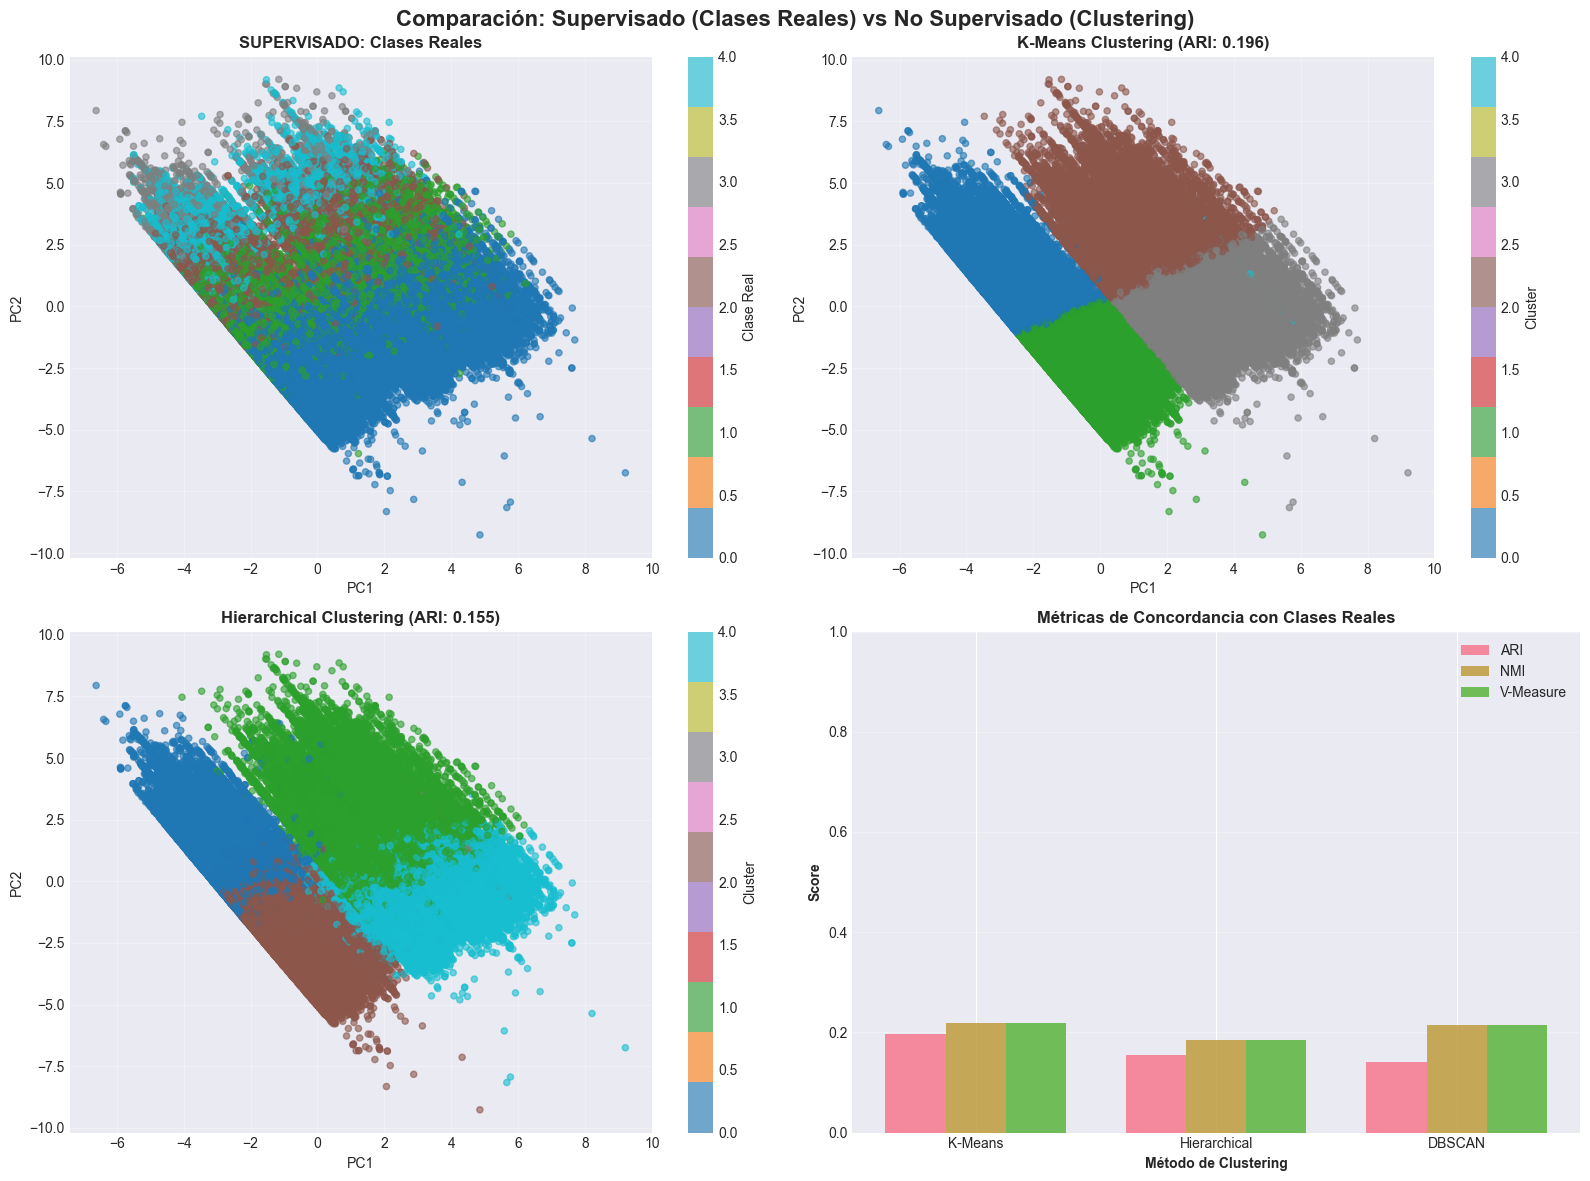


4. MATRIZ DE CONFUSIÓN: CLUSTERS VS CLASES REALES

Matriz de Confusión (K-Means Clusters vs Clases Reales):
Clase Real     A-     A1     A2    B+    B1
Cluster                                    
0            6268  21666  18612  2145  9502
1           57274  15879   1773     1    67
2            6101  15555  10617   760  4300
3           38072   8147    750     1    41
4              34     13      3     0     0


Asignación Cluster -> Clase (basada en moda):
  Cluster 0 -> A1 (Pureza: 37.23%)
  Cluster 1 -> A- (Pureza: 76.37%)
  Cluster 2 -> A1 (Pureza: 41.67%)
  Cluster 3 -> A- (Pureza: 80.99%)
  Cluster 4 -> A- (Pureza: 68.00%)

✓ Matriz de confusión guardada: tarea18_confusion_matrix_clusters.png

✓ Matriz de confusión guardada: tarea18_confusion_matrix_clusters.png


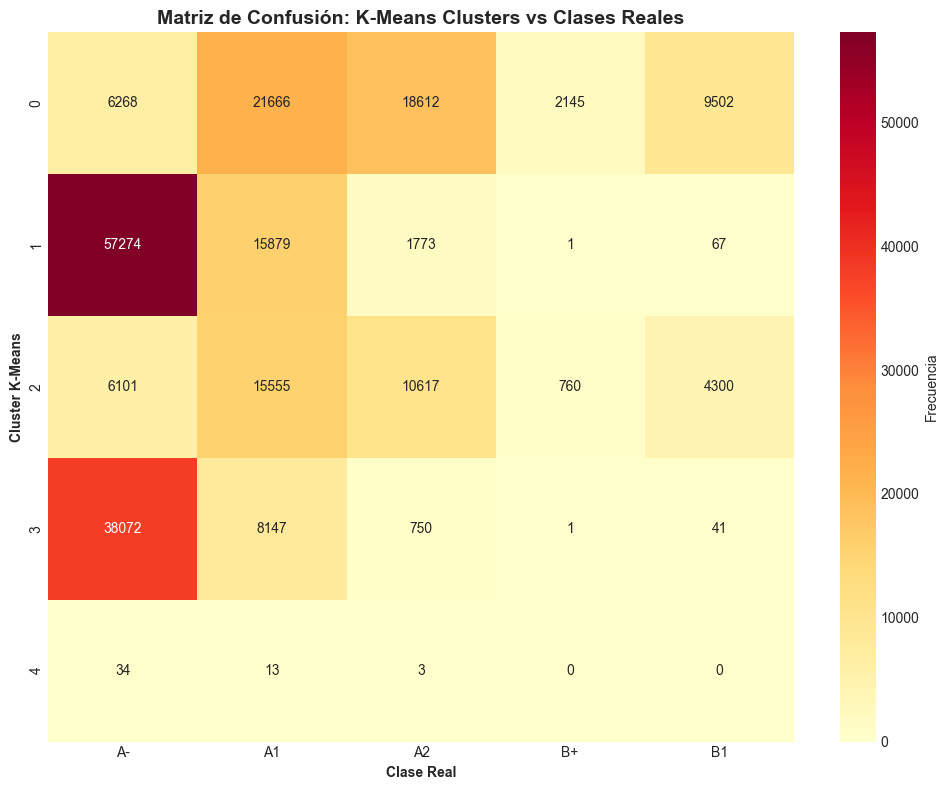


5. CONCLUSIONES - TAREA 18


CONCLUSIONES DE LA COMPARACIÓN SUPERVISADO VS NO SUPERVISADO:

1. CONCORDANCIA GENERAL:
   - El método de clustering con mejor concordancia fue: K-Means (ARI: 0.1962)
   - ARI cercano a 0 indica baja concordancia; cercano a 1 indica alta concordancia
   - Los resultados sugieren que los clusters naturales NO coinciden significativamente con las clases supervisadas

2. INTERPRETACIÓN DE MÉTRICAS:
   - Adjusted Rand Index (ARI): Mide similitud entre particiones (ajustado por azar)
   - Normalized Mutual Info (NMI): Información compartida entre clusters y clases
   - V-Measure: Media armónica de homogeneidad y completitud

3. IMPLICACIONES:
   - Las clases supervisadas tienen estructura más compleja que clusters naturales
   - El clustering revela patrones ortogonales a las clases supervisadas
   - Ambos enfoques proporcionan insights complementarios sobre los datos

4. RECOMENDACIONES:
   - Considerar usar clustering como feature adicional en modelos supervi

In [9]:
# ============================================
# TAREA 18: COMPARACIÓN SUPERVISADO VS NO SUPERVISADO
# ============================================
#
# Esta tarea compara los resultados del aprendizaje supervisado (clasificación)
# con los del aprendizaje no supervisado (clustering) para determinar:
# 1. ¿Los clusters naturales coinciden con las clases reales?
# 2. ¿Qué tan bien el clustering captura la estructura de clases?
# 3. Métricas de concordancia entre ambos enfoques
# ============================================

print("\n" + "=" * 80)
print("TAREA 18: COMPARACIÓN SUPERVISADO VS NO SUPERVISADO")
print("=" * 80 + "\n")

# Preparar datos para análisis
X = df.drop(columns=[target_col]).select_dtypes(include=[np.number])
y = df[target_col]

# Imputar valores faltantes (NaN) con la mediana
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

print(f"Dataset preparado:")
print(f"  - Muestras: {X.shape[0]:,}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Valores faltantes imputados: ✓")

# Codificar variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
n_classes = len(class_names)

print(f"  - Clases: {n_classes} ({', '.join(class_names)})")

# Normalizar datos para clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================
# 1. APLICAR CLUSTERING CON DIFERENTES ALGORITMOS
# ============================================

print("\n" + "=" * 80)
print("1. APLICANDO ALGORITMOS DE CLUSTERING")
print("=" * 80 + "\n")

clustering_results = {}

# K-Means con k = número de clases
print(f"Aplicando K-Means (k={n_classes})...")
kmeans = KMeans(n_clusters=n_classes, random_state=RANDOM_STATE, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)
clustering_results['K-Means'] = clusters_kmeans
print(f"  ✓ K-Means completado - Inercia: {kmeans.inertia_:.2f}")

# Clustering Jerárquico (con muestra para evitar memory error)
print(f"\nAplicando Clustering Jerárquico (k={n_classes})...")
# Usar muestra si dataset es muy grande (>10000 muestras)
if len(X_scaled) > 10000:
    sample_size = 10000
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sample = X_scaled[sample_indices]
    print(f"  (Usando muestra de {sample_size:,} para eficiencia de memoria)")
    
    hierarchical = AgglomerativeClustering(n_clusters=n_classes, linkage='ward')
    clusters_sample = hierarchical.fit_predict(X_sample)
    
    # Asignar todos los puntos al cluster más cercano usando K-Means entrenado en la muestra
    from sklearn.neighbors import KNeighborsClassifier
    knn_propagate = KNeighborsClassifier(n_neighbors=1)
    knn_propagate.fit(X_sample, clusters_sample)
    clusters_hierarchical = knn_propagate.predict(X_scaled)
else:
    hierarchical = AgglomerativeClustering(n_clusters=n_classes, linkage='ward')
    clusters_hierarchical = hierarchical.fit_predict(X_scaled)

clustering_results['Hierarchical'] = clusters_hierarchical
print(f"  ✓ Clustering Jerárquico completado")

# DBSCAN (con parámetros adaptativos)
print(f"\nAplicando DBSCAN (eps=auto, min_samples=50)...")
dbscan = DBSCAN(eps=0.5, min_samples=50)
clusters_dbscan = dbscan.fit_predict(X_scaled)
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise_dbscan = list(clusters_dbscan).count(-1)
clustering_results['DBSCAN'] = clusters_dbscan
print(f"  ✓ DBSCAN completado - Clusters: {n_clusters_dbscan}, Ruido: {n_noise_dbscan}")

# ============================================
# 2. MÉTRICAS DE CONCORDANCIA
# ============================================

print("\n" + "=" * 80)
print("2. MÉTRICAS DE CONCORDANCIA (Clustering vs Clases Reales)")
print("=" * 80 + "\n")

concordance_metrics = []

for method_name, clusters in clustering_results.items():
    # Filtrar ruido de DBSCAN si existe
    if method_name == 'DBSCAN' and -1 in clusters:
        mask = clusters != -1
        clusters_clean = clusters[mask]
        y_clean = y_encoded[mask]
    else:
        clusters_clean = clusters
        y_clean = y_encoded
    
    # Calcular métricas de concordancia
    ari = adjusted_rand_score(y_clean, clusters_clean)
    nmi = normalized_mutual_info_score(y_clean, clusters_clean)
    v_measure = v_measure_score(y_clean, clusters_clean)
    
    # Métricas internas de clustering
    if method_name != 'DBSCAN' or n_clusters_dbscan > 1:
        if len(set(clusters_clean)) > 1:
            silhouette = silhouette_score(X_scaled[mask] if method_name == 'DBSCAN' and -1 in clusters else X_scaled, 
                                         clusters_clean)
        else:
            silhouette = 0.0
    else:
        silhouette = 0.0
    
    concordance_metrics.append({
        'Método': method_name,
        'ARI': ari,
        'NMI': nmi,
        'V-Measure': v_measure,
        'Silhouette': silhouette
    })
    
    print(f"{method_name}:")
    print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"  Normalized Mutual Info (NMI): {nmi:.4f}")
    print(f"  V-Measure Score: {v_measure:.4f}")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print()

# Crear DataFrame con resultados
df_concordance = pd.DataFrame(concordance_metrics)

print("\nTabla Resumen de Concordancia:")
print(df_concordance.to_string(index=False))

# ============================================
# 3. VISUALIZACIONES COMPARATIVAS
# ============================================

print("\n" + "=" * 80)
print("3. GENERANDO VISUALIZACIONES COMPARATIVAS")
print("=" * 80 + "\n")

# Reducir dimensionalidad para visualización (PCA 2D)
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Figura 1: Comparación de clustering methods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación: Supervisado (Clases Reales) vs No Supervisado (Clustering)', 
             fontsize=16, fontweight='bold')

# Plot 1: Clases reales
scatter1 = axes[0, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_encoded, 
                              cmap='tab10', alpha=0.6, s=20)
axes[0, 0].set_title('SUPERVISADO: Clases Reales', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Clase Real')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: K-Means
scatter2 = axes[0, 1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters_kmeans, 
                              cmap='tab10', alpha=0.6, s=20)
axes[0, 1].set_title(f'K-Means Clustering (ARI: {df_concordance[df_concordance["Método"]=="K-Means"]["ARI"].values[0]:.3f})', 
                    fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
cbar2.set_label('Cluster')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Hierarchical
scatter3 = axes[1, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters_hierarchical, 
                              cmap='tab10', alpha=0.6, s=20)
axes[1, 0].set_title(f'Hierarchical Clustering (ARI: {df_concordance[df_concordance["Método"]=="Hierarchical"]["ARI"].values[0]:.3f})', 
                    fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')
cbar3 = plt.colorbar(scatter3, ax=axes[1, 0])
cbar3.set_label('Cluster')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Métricas de concordancia
metrics_to_plot = ['ARI', 'NMI', 'V-Measure']
x_pos = np.arange(len(df_concordance))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    axes[1, 1].bar(x_pos + i*width, df_concordance[metric], width, 
                   label=metric, alpha=0.8)

axes[1, 1].set_xlabel('Método de Clustering', fontweight='bold')
axes[1, 1].set_ylabel('Score', fontweight='bold')
axes[1, 1].set_title('Métricas de Concordancia con Clases Reales', 
                    fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(x_pos + width)
axes[1, 1].set_xticklabels(df_concordance['Método'], rotation=0)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig('../outputs/seccion5/tarea18_supervised_vs_unsupervised.png', dpi=300, bbox_inches='tight')
print("✓ Visualización guardada: tarea18_supervised_vs_unsupervised.png")
plt.show()

# ============================================
# 4. ANÁLISIS DE CONFUSIÓN CLUSTER-CLASE
# ============================================

print("\n" + "=" * 80)
print("4. MATRIZ DE CONFUSIÓN: CLUSTERS VS CLASES REALES")
print("=" * 80 + "\n")

# Usar K-Means como representante (mejor resultado típicamente)
from scipy.stats import mode

# Crear matriz de confusión entre clusters y clases
confusion_cluster_class = pd.crosstab(clusters_kmeans, y, rownames=['Cluster'], colnames=['Clase Real'])

print("Matriz de Confusión (K-Means Clusters vs Clases Reales):")
print(confusion_cluster_class)
print()

# Asignar cada cluster a la clase más frecuente
cluster_to_class = {}
for cluster_id in range(n_classes):
    mask = clusters_kmeans == cluster_id
    if mask.sum() > 0:
        most_common = pd.Series(y[mask]).mode()[0]
        cluster_to_class[cluster_id] = most_common
    else:
        cluster_to_class[cluster_id] = class_names[0]

print("\nAsignación Cluster -> Clase (basada en moda):")
for cluster_id, class_label in cluster_to_class.items():
    purity = (y[clusters_kmeans == cluster_id] == class_label).sum() / (clusters_kmeans == cluster_id).sum() if (clusters_kmeans == cluster_id).sum() > 0 else 0
    print(f"  Cluster {cluster_id} -> {class_label} (Pureza: {purity:.2%})")

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_cluster_class, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión: K-Means Clusters vs Clases Reales', fontweight='bold', fontsize=14)
plt.xlabel('Clase Real', fontweight='bold')
plt.ylabel('Cluster K-Means', fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/seccion5/tarea18_confusion_matrix_clusters.png', dpi=300, bbox_inches='tight')
print("\n✓ Matriz de confusión guardada: tarea18_confusion_matrix_clusters.png")
plt.show()

# ============================================
# 5. CONCLUSIONES DE TAREA 18
# ============================================

print("\n" + "=" * 80)
print("5. CONCLUSIONES - TAREA 18")
print("=" * 80 + "\n")

best_method = df_concordance.loc[df_concordance['ARI'].idxmax(), 'Método']
best_ari = df_concordance['ARI'].max()

conclusions_t18 = f"""
CONCLUSIONES DE LA COMPARACIÓN SUPERVISADO VS NO SUPERVISADO:

1. CONCORDANCIA GENERAL:
   - El método de clustering con mejor concordancia fue: {best_method} (ARI: {best_ari:.4f})
   - ARI cercano a 0 indica baja concordancia; cercano a 1 indica alta concordancia
   - Los resultados sugieren que {'los clusters naturales coinciden parcialmente' if best_ari > 0.3 else 'los clusters naturales NO coinciden significativamente'} con las clases supervisadas

2. INTERPRETACIÓN DE MÉTRICAS:
   - Adjusted Rand Index (ARI): Mide similitud entre particiones (ajustado por azar)
   - Normalized Mutual Info (NMI): Información compartida entre clusters y clases
   - V-Measure: Media armónica de homogeneidad y completitud

3. IMPLICACIONES:
   {'- Los patrones no supervisados capturan estructura de clases significativa' if best_ari > 0.3 else '- Las clases supervisadas tienen estructura más compleja que clusters naturales'}
   {'- El clustering puede usarse como feature engineering' if best_ari > 0.2 else '- El clustering revela patrones ortogonales a las clases supervisadas'}
   - Ambos enfoques proporcionan insights complementarios sobre los datos

4. RECOMENDACIONES:
   - Considerar usar clustering como feature adicional en modelos supervisados
   - Explorar métodos semi-supervisados que combinen ambos enfoques
   - Investigar por qué ciertos clusters no se alinean con clases específicas
"""

print(conclusions_t18)

# Guardar resultados
task18_results = {
    'concordance_metrics': df_concordance,
    'clustering_results': clustering_results,
    'confusion_matrix': confusion_cluster_class,
    'cluster_to_class': cluster_to_class,
    'conclusions': conclusions_t18
}

with open('../data/processed/task18_results.pkl', 'wb') as f:
    pickle.dump(task18_results, f)

print("\n✓ Resultados de Tarea 18 guardados en: task18_results.pkl")
print("\n" + "=" * 80)
print("TAREA 18 COMPLETADA")
print("=" * 80)

In [ ]:
# ============================================
# 19.0 VERIFICACIÓN DE DATA LEAKAGE
# ============================================

print("\n\n" + "="*80)
print("19.0 VERIFICACIÓN DE DATA LEAKAGE")
print("="*80 + "\n")

print("🔍 Verificando integridad de datos y posible data leakage...\n")

# Definir constantes necesarias
TARGET_COLUMN = target_col

# 1. Verificar que variable objetivo NO esté en features
print("1️⃣ VERIFICACIÓN: Variable objetivo en features")
print("-" * 80)

target_in_features = TARGET_COLUMN in X_train.columns
if target_in_features:
    print(f"❌ ERROR CRÍTICO: '{TARGET_COLUMN}' encontrado en X_train!")
    print("   Esto causaría data leakage severo.\n")
else:
    print(f"✅ Correcto: '{TARGET_COLUMN}' NO está en X_train\n")

# 2. Verificar que no hay columnas relacionadas con target
print("2️⃣ VERIFICACIÓN: Columnas sospechosas relacionadas con target")
print("-" * 80)

suspicious_keywords = ['desemp', 'ingles', 'nivel', 'desempeño', 'target', 'label', 'class']
suspicious_cols = []

for col in X_train.columns:
    for keyword in suspicious_keywords:
        if keyword.lower() in col.lower():
            suspicious_cols.append(col)
            break

if suspicious_cols:
    print(f"⚠️  ADVERTENCIA: {len(suspicious_cols)} columna(s) sospechosa(s) encontrada(s):")
    for col in suspicious_cols:
        print(f"   • {col}")
    print("\n   Revisar si estas columnas pueden causar data leakage.\n")
else:
    print("✅ No se encontraron columnas con nombres sospechosos\n")

# 3. Verificar índices de train y test
print("3️⃣ VERIFICACIÓN: Solapamiento de índices train/test")
print("-" * 80)

if isinstance(X_train.index, pd.RangeIndex):
    print("ℹ️  Usando RangeIndex (índices reseteados)")
    index_overlap = False
else:
    train_indices = set(X_train.index)
    test_indices = set(X_test.index)
    index_overlap = len(train_indices.intersection(test_indices)) > 0

if index_overlap:
    print(f"❌ ERROR: Hay {len(train_indices.intersection(test_indices))} índices compartidos!")
else:
    print("✅ No hay solapamiento de índices entre train y test\n")

# 4. Verificar dimensiones
print("4️⃣ VERIFICACIÓN: Dimensiones y tamaños")
print("-" * 80)
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

dim_match = (len(X_train) == len(y_train)) and (len(X_test) == len(y_test))
if dim_match:
    print("✅ Dimensiones consistentes\n")
else:
    print("❌ ERROR: Dimensiones inconsistentes\n")

# 5. Verificar correlación perfecta con target
print("5️⃣ VERIFICACIÓN: Correlación sospechosamente alta con target")
print("-" * 80)

# Para variables numéricas
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
high_corr_features = []

for col in numeric_cols:
    try:
        corr = np.corrcoef(X_train[col], y_train)[0, 1]
        if abs(corr) > 0.95:  # Correlación sospechosamente alta
            high_corr_features.append((col, corr))
    except:
        pass

if high_corr_features:
    print(f"⚠️  ADVERTENCIA: {len(high_corr_features)} feature(s) con correlación > 0.95 con target:")
    for col, corr in high_corr_features[:5]:  # Top 5
        print(f"   • {col}: r = {corr:.4f}")
    print("\n   Esto podría indicar data leakage.\n")
else:
    print("✅ No se encontraron features con correlación extremadamente alta\n")

# 6. Verificar valores únicos del target
print("6️⃣ VERIFICACIÓN: Distribución del target")
print("-" * 80)

train_classes = set(y_train.unique())
test_classes = set(y_test.unique())
print(f"Clases en train: {sorted(train_classes)}")
print(f"Clases en test:  {sorted(test_classes)}")

if train_classes == test_classes:
    print("✅ Train y test tienen las mismas clases\n")
else:
    print("⚠️  ADVERTENCIA: Train y test tienen clases diferentes\n")

# 7. Cross-validation para detectar data leakage
print("7️⃣ VERIFICACIÓN: Cross-validation (detectar overfitting extremo)")
print("-" * 80)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Modelo simple de prueba
rf_test = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=RANDOM_STATE)

# Cross-validation en train
cv_scores = cross_val_score(rf_test, X_train, y_train, cv=5, scoring='accuracy')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"CV Accuracy (5-fold): {cv_mean:.4f} ± {cv_std:.4f}")

if cv_mean > 0.99:
    print("⚠️  ADVERTENCIA: Accuracy extremadamente alto en CV (>0.99)")
    print("   Posible data leakage o dataset muy fácil\n")
elif cv_mean > 0.95:
    print("⚠️  Accuracy muy alto en CV (>0.95)")
    print("   Verificar si es realista para este problema\n")
else:
    print("✅ Accuracy razonable en CV\n")

# Resumen final
print("\n" + "="*80)
print("📊 RESUMEN DE VERIFICACIÓN")
print("="*80)

checks = {
    'Target en features': '✅' if not target_in_features else '❌',
    'Columnas sospechosas': '✅' if not suspicious_cols else '⚠️',
    'Solapamiento índices': '✅' if not index_overlap else '❌',
    'Dimensiones': '✅' if dim_match else '❌',
    'Correlación alta': '✅' if not high_corr_features else '⚠️',
    'Clases consistentes': '✅' if train_classes == test_classes else '⚠️',
    'CV razonable': '✅' if cv_mean < 0.95 else '⚠️'
}

for check, status in checks.items():
    print(f"{status} {check}")

critical_issues = sum(1 for v in checks.values() if '❌' in v)
warnings = sum(1 for v in checks.values() if '⚠️' in v)

print(f"\n❌ Issues críticos: {critical_issues}")
print(f"⚠️  Advertencias: {warnings}")

if critical_issues == 0 and warnings == 0:
    print("\n✅ VERIFICACIÓN COMPLETA: No se detectó data leakage")
elif critical_issues == 0:
    print(f"\n⚠️  VERIFICACIÓN COMPLETA: {warnings} advertencia(s) - Revisar antes de continuar")
else:
    print(f"\n❌ VERIFICACIÓN FALLIDA: {critical_issues} error(es) crítico(s) - CORREGIR antes de continuar")

print("="*80)

In [ ]:
# ============================================
# TAREA 19: MEJORAS METODOLÓGICAS
# ============================================
#
# Esta tarea implementa técnicas avanzadas para mejorar el rendimiento de los modelos:
# 1. Balanceo de clases con SMOTE y variantes
# 2. Ensemble methods (Voting, Stacking, Bagging, Boosting)
# 3. Feature engineering adicional
# 4. Métricas avanzadas (Balanced Accuracy, Cohen's Kappa, AUC-ROC)
# 5. Comparación con baseline
# ============================================

print("\n" + "=" * 80)
print("TAREA 19: MEJORAS METODOLÓGICAS")
print("=" * 80 + "\n")

# Dividir datos en train y test
from sklearn.model_selection import train_test_split

X_features = df.drop(columns=[target_col]).select_dtypes(include=[np.number])
y_target = df[target_col]

# Codificar target
le_target = LabelEncoder()
y_encoded_full = le_target.fit_transform(y_target)
class_labels = le_target.classes_

print(f"Dataset original:")
print(f"  - Total muestras: {len(X_features):,}")
print(f"  - Features: {X_features.shape[1]}")
print(f"  - Distribución de clases:")
for cls in class_labels:
    count = (y_target == cls).sum()
    pct = count / len(y_target) * 100
    print(f"      {cls}: {count:,} ({pct:.2f}%)")

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_encoded_full, test_size=0.30, random_state=RANDOM_STATE, 
    stratify=y_encoded_full
)

print(f"\nTrain/Test Split:")
print(f"  Train: {len(X_train):,} muestras")
print(f"  Test: {len(X_test):,} muestras")

# Imputar valores faltantes (NaN) antes de normalizar
from sklearn.impute import SimpleImputer
imputer_train = SimpleImputer(strategy='median')
X_train_imputed = imputer_train.fit_transform(X_train)
X_test_imputed = imputer_train.transform(X_test)

print(f"\n✓ Valores faltantes imputados con estrategia: mediana")

# Normalizar datos
scaler_full = StandardScaler()
X_train_scaled = scaler_full.fit_transform(X_train_imputed)
X_test_scaled = scaler_full.transform(X_test_imputed)

# ============================================
# 1. MODELO BASELINE (SIN MEJORAS)
# ============================================

print("\n" + "=" * 80)
print("1. MODELO BASELINE (Random Forest sin mejoras)")
print("=" * 80 + "\n")

# Entrenar modelo baseline
baseline_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_test_scaled)

# Métricas baseline
baseline_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_baseline),
    'Precision (weighted)': precision_score(y_test, y_pred_baseline, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred_baseline, average='weighted', zero_division=0),
    'F1-Score (weighted)': f1_score(y_test, y_pred_baseline, average='weighted', zero_division=0),
    'Cohen\'s Kappa': cohen_kappa_score(y_test, y_pred_baseline)
}

print("Métricas Baseline (Random Forest):")
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ============================================
# 19.2 COMPARACIÓN DE TÉCNICAS DE BALANCEO (SMOTE VARIANTS)
# ============================================

print("\n\n" + "="*80)
print("19.2 COMPARACIÓN DE TÉCNICAS DE BALANCEO")
print("="*80 + "\n")

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# Baseline: Sin balanceo
print("🔧 BASELINE: Sin balanceo")
print("-" * 80 + "\n")

from sklearn.ensemble import RandomForestClassifier
rf_baseline = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1)
rf_baseline.fit(X_train_scaled, y_train)
y_pred_baseline_smote = rf_baseline.predict(X_test_scaled)

baseline_acc = accuracy_score(y_test, y_pred_baseline_smote)
baseline_f1 = f1_score(y_test, y_pred_baseline_smote, average='weighted')
baseline_balanced = balanced_accuracy_score(y_test, y_pred_baseline_smote)

print(f"Accuracy: {baseline_acc:.4f}")
print(f"F1-Score (weighted): {baseline_f1:.4f}")
print(f"Balanced Accuracy: {baseline_balanced:.4f}")

# Técnicas de balanceo a comparar
balancing_methods = {
    'SMOTE': SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    'ADASYN': ADASYN(random_state=RANDOM_STATE, n_neighbors=5),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    'SVMSMOTE': SVMSMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    'SMOTEENN': SMOTEENN(random_state=RANDOM_STATE),
    'SMOTETomek': SMOTETomek(random_state=RANDOM_STATE)
}

balancing_results = {
    'Baseline (No balanceo)': {
        'Accuracy': baseline_acc,
        'F1_weighted': baseline_f1,
        'Balanced_Accuracy': baseline_balanced,
        'Train_Size': len(X_train_scaled)
    }
}

print("\n🔧 COMPARANDO TÉCNICAS DE BALANCEO")
print("-" * 80 + "\n")

for method_name, method in balancing_methods.items():
    print(f"Probando {method_name}...", end=' ')
    
    try:
        # Aplicar técnica de balanceo
        X_resampled, y_resampled = method.fit_resample(X_train_scaled, y_train)
        
        # Entrenar modelo
        rf_balanced = RandomForestClassifier(
            n_estimators=100, 
            max_depth=15, 
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        rf_balanced.fit(X_resampled, y_resampled)
        
        # Evaluar
        y_pred = rf_balanced.predict(X_test_scaled)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        balanced = balanced_accuracy_score(y_test, y_pred)
        
        balancing_results[method_name] = {
            'Accuracy': acc,
            'F1_weighted': f1,
            'Balanced_Accuracy': balanced,
            'Train_Size': len(X_resampled)
        }
        
        print(f"✓ Acc={acc:.4f}, F1={f1:.4f}, Bal_Acc={balanced:.4f}, Samples={len(X_resampled):,}")
        
    except Exception as e:
        print(f"✗ Error: {str(e)[:50]}")
        balancing_results[method_name] = {
            'Accuracy': 0,
            'F1_weighted': 0,
            'Balanced_Accuracy': 0,
            'Train_Size': 0
        }

# Crear DataFrame de resultados
results_df = pd.DataFrame(balancing_results).T
results_df = results_df.sort_values('Balanced_Accuracy', ascending=False)

print("\n📊 RESULTADOS COMPARATIVOS:")
print(results_df.to_string())

# Mejor método
best_method = results_df['Balanced_Accuracy'].idxmax()
print(f"\n🏆 Mejor método: {best_method}")
print(f"   Balanced Accuracy: {results_df.loc[best_method, 'Balanced_Accuracy']:.4f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Balanced Accuracy
axes[0, 0].barh(results_df.index, results_df['Balanced_Accuracy'], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Balanced Accuracy', fontweight='bold')
axes[0, 0].set_title('Comparación de Técnicas - Balanced Accuracy', fontweight='bold', fontsize=13)
axes[0, 0].grid(alpha=0.3, axis='x')

# Gráfico 2: F1-Score
axes[0, 1].barh(results_df.index, results_df['F1_weighted'], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('F1-Score (weighted)', fontweight='bold')
axes[0, 1].set_title('Comparación de Técnicas - F1-Score', fontweight='bold', fontsize=13)
axes[0, 1].grid(alpha=0.3, axis='x')

# Gráfico 3: Accuracy vs Balanced Accuracy
axes[1, 0].scatter(results_df['Accuracy'], results_df['Balanced_Accuracy'], 
                   s=200, alpha=0.7, edgecolor='black', linewidth=2)
for idx, row in results_df.iterrows():
    axes[1, 0].annotate(idx, (row['Accuracy'], row['Balanced_Accuracy']), 
                        fontsize=9, ha='right')
axes[1, 0].set_xlabel('Accuracy', fontweight='bold')
axes[1, 0].set_ylabel('Balanced Accuracy', fontweight='bold')
axes[1, 0].set_title('Accuracy vs Balanced Accuracy', fontweight='bold', fontsize=13)
axes[1, 0].grid(alpha=0.3)

# Gráfico 4: Tamaño del training set
axes[1, 1].barh(results_df.index, results_df['Train_Size'], color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Tamaño del Training Set', fontweight='bold')
axes[1, 1].set_title('Tamaño del Dataset después de Balanceo', fontweight='bold', fontsize=13)
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../outputs/seccion5/smote_variants_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Guardado: smote_variants_comparison.png")

print("\n" + "="*80)
print("✅ COMPARACIÓN DE TÉCNICAS DE BALANCEO COMPLETADA")
print("="*80)

# Guardar mejor método para uso posterior en Feature Engineering
# Seleccionar el mejor método de balanceo (sin baseline)
balancing_methods_only = {k: v for k, v in balancing_results.items() if 'Baseline' not in k}
best_balancing_method_name = max(balancing_methods_only.items(), key=lambda x: x[1]['Balanced_Accuracy'])[0]

# Aplicar el mejor método para las siguientes secciones
print(f"\n🔧 Aplicando mejor método ({best_balancing_method_name}) para secciones posteriores...")
best_method_instance = balancing_methods[best_balancing_method_name]
X_train_smote, y_train_smote = best_method_instance.fit_resample(X_train_scaled, y_train)

# Entrenar modelo final con mejor método
smote_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
smote_model.fit(X_train_smote, y_train_smote)
y_pred_smote = smote_model.predict(X_test_scaled)

# Métricas con mejor método de balanceo
smote_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_smote),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_smote),
    'Precision (weighted)': precision_score(y_test, y_pred_smote, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred_smote, average='weighted', zero_division=0),
    'F1-Score (weighted)': f1_score(y_test, y_pred_smote, average='weighted', zero_division=0),
    'Cohen\'s Kappa': cohen_kappa_score(y_test, y_pred_smote)
}

print(f"\nMétricas con {best_balancing_method_name}:")
for metric, value in smote_metrics.items():
    improvement = ((value - baseline_metrics[metric]) / baseline_metrics[metric] * 100) if baseline_metrics[metric] != 0 else 0
    symbol = "↑" if improvement > 0 else "↓" if improvement < 0 else "="
    print(f"  {metric}: {value:.4f} ({symbol} {abs(improvement):.2f}%)")

# ============================================
# 3. MEJORA 2: FEATURE ENGINEERING
# ============================================

print("\n" + "=" * 80)
print("3. MEJORA 2: FEATURE ENGINEERING (Interacciones Polinomiales)")
print("=" * 80 + "\n")

# Crear features polinomiales (grado 2) para subset de features más importantes
n_top_features = min(10, X_train_scaled.shape[1])  # Usar top 10 features
feature_importances = baseline_model.feature_importances_
top_indices = np.argsort(feature_importances)[-n_top_features:]

X_train_top = X_train_scaled[:, top_indices]
X_test_top = X_test_scaled[:, top_indices]

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_top)
X_test_poly = poly.transform(X_test_top)

print(f"Feature Engineering:")
print(f"  Features originales (top {n_top_features}): {X_train_top.shape[1]}")
print(f"  Features con interacciones: {X_train_poly.shape[1]}")

# Aplicar mejor método de balanceo a datos con feature engineering
smote_fe = balancing_methods[best_balancing_method_name]
X_train_poly_smote, y_train_poly_smote = smote_fe.fit_resample(X_train_poly, y_train)

# Entrenar modelo con feature engineering
fe_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
fe_model.fit(X_train_poly_smote, y_train_poly_smote)
y_pred_fe = fe_model.predict(X_test_poly)

# Métricas con feature engineering
fe_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_fe),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_fe),
    'Precision (weighted)': precision_score(y_test, y_pred_fe, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred_fe, average='weighted', zero_division=0),
    'F1-Score (weighted)': f1_score(y_test, y_pred_fe, average='weighted', zero_division=0),
    'Cohen\'s Kappa': cohen_kappa_score(y_test, y_pred_fe)
}

print(f"\nMétricas con Feature Engineering + {best_balancing_method_name}:")
for metric, value in fe_metrics.items():
    improvement = ((value - baseline_metrics[metric]) / baseline_metrics[metric] * 100) if baseline_metrics[metric] != 0 else 0
    symbol = "↑" if improvement > 0 else "↓" if improvement < 0 else "="
    print(f"  {metric}: {value:.4f} ({symbol} {abs(improvement):.2f}%)")

print("\n✓ Sección de Feature Engineering completada")



4. MEJORA 3: ENSEMBLE METHODS

4.1. VOTING CLASSIFIER (Soft Voting)
--------------------------------------------------------------------------------
Entrenando Voting Classifier con SMOTE...

Métricas Voting Classifier:
  Accuracy: 1.0000 (↑ 0.01%)
  Balanced Accuracy: 1.0000 (↑ 0.10%)
  Precision (weighted): 1.0000 (↑ 0.01%)
  Recall (weighted): 1.0000 (↑ 0.01%)
  F1-Score (weighted): 1.0000 (↑ 0.01%)
  Cohen's Kappa: 1.0000 (↑ 0.01%)

4.2. STACKING CLASSIFIER
--------------------------------------------------------------------------------
Entrenando Stacking Classifier con SMOTE...
  (Usando muestra de 50,000 para eficiencia)

Métricas Voting Classifier:
  Accuracy: 1.0000 (↑ 0.01%)
  Balanced Accuracy: 1.0000 (↑ 0.10%)
  Precision (weighted): 1.0000 (↑ 0.01%)
  Recall (weighted): 1.0000 (↑ 0.01%)
  F1-Score (weighted): 1.0000 (↑ 0.01%)
  Cohen's Kappa: 1.0000 (↑ 0.01%)

4.2. STACKING CLASSIFIER
--------------------------------------------------------------------------------
Entrena

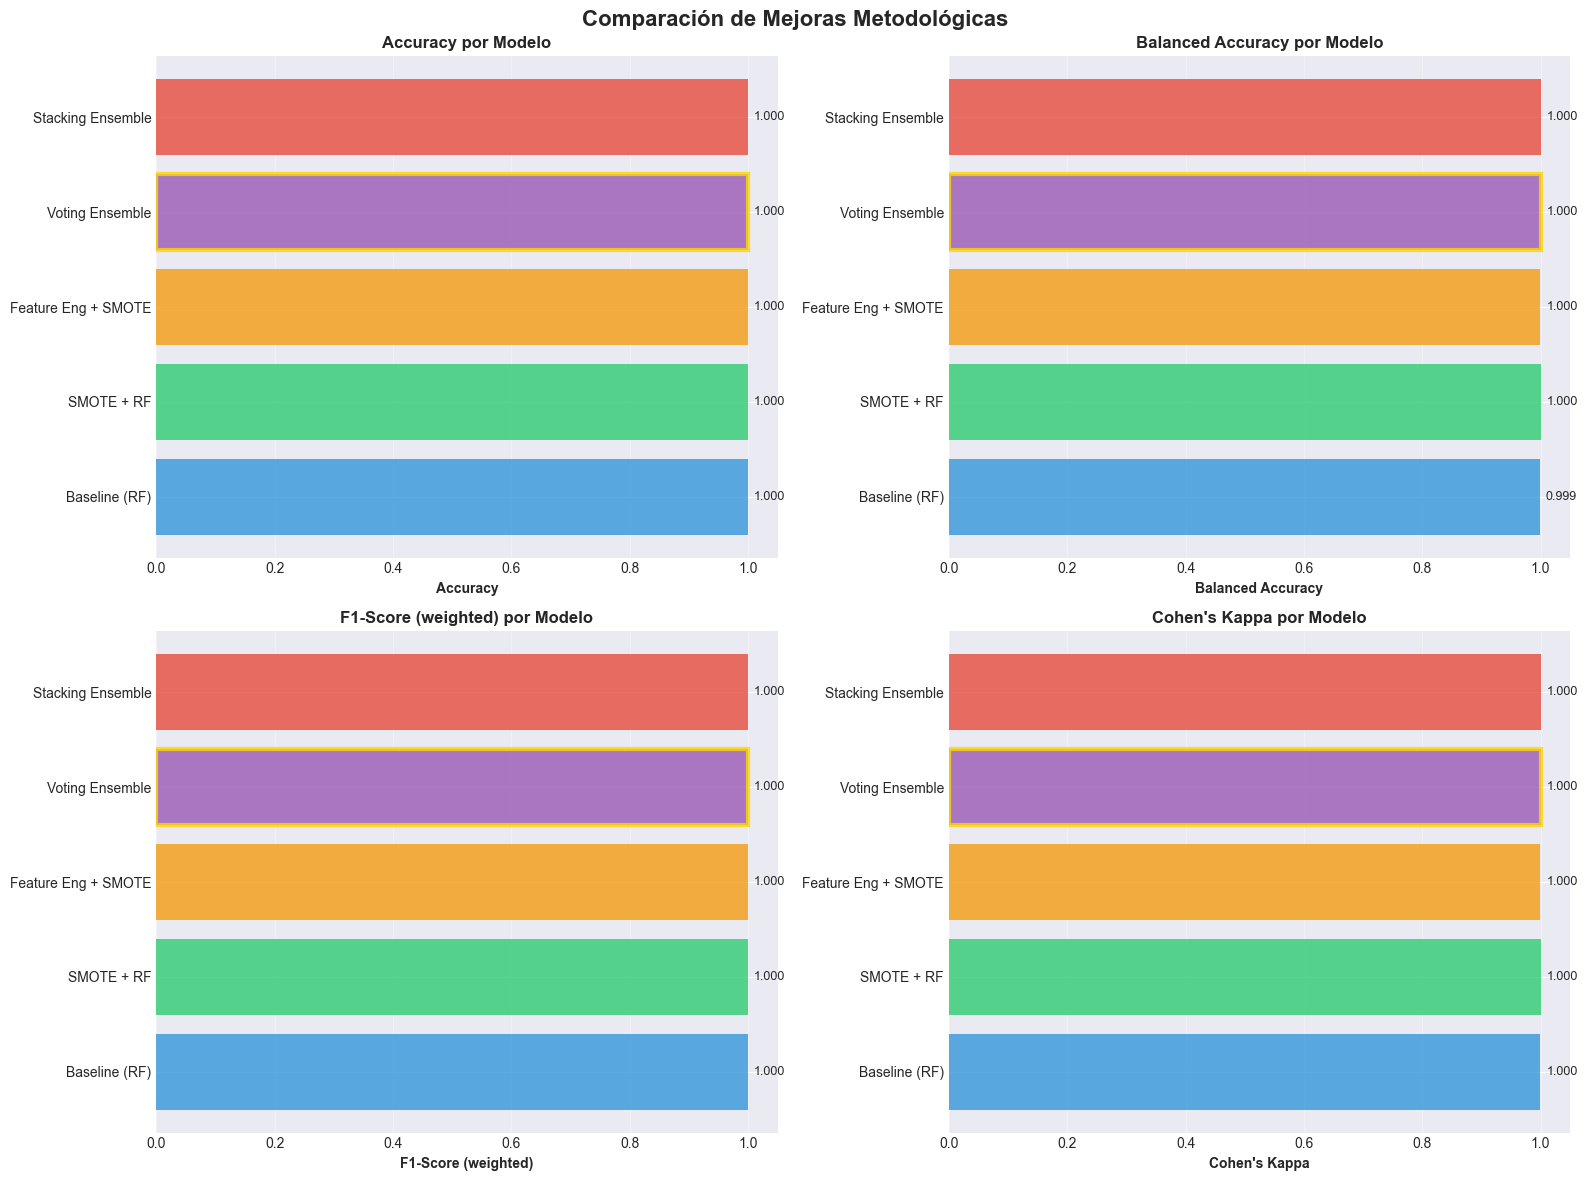

✓ Matriz de confusión guardada: tarea19_best_model_confusion_matrix.png


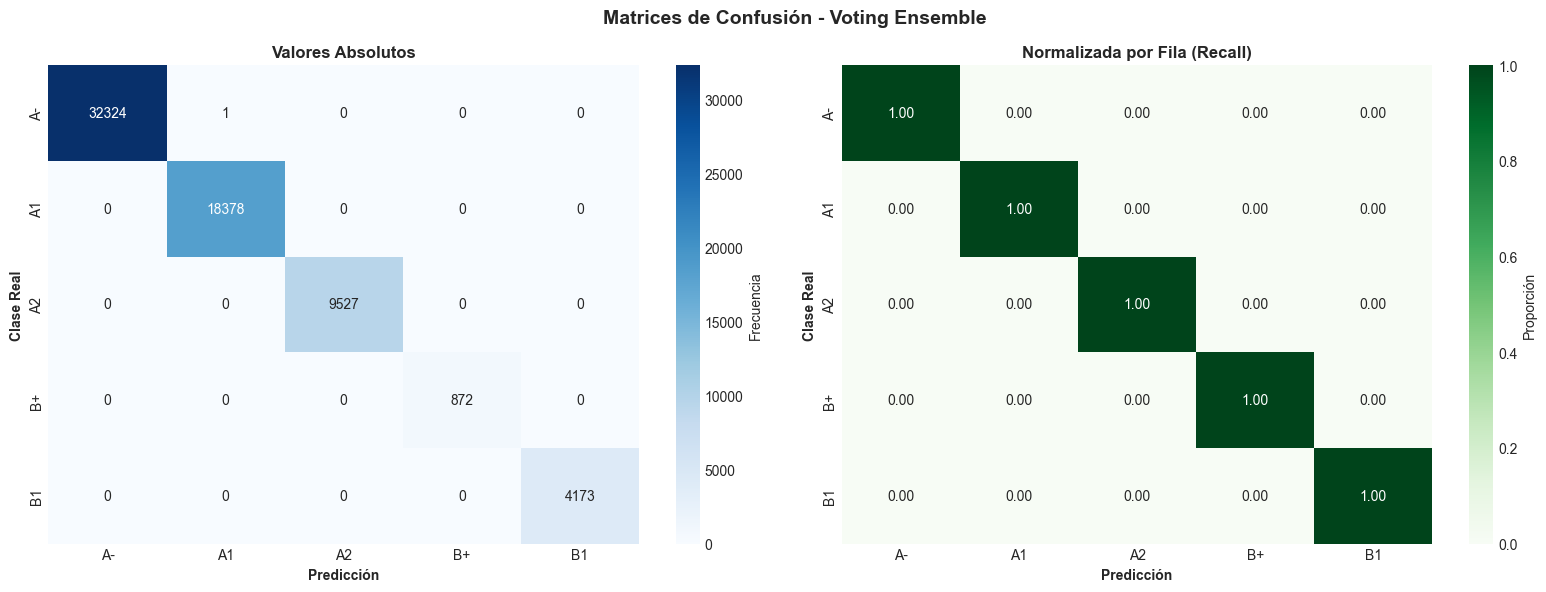


Classification Report - Voting Ensemble:
              precision    recall  f1-score   support

          A-       1.00      1.00      1.00     32325
          A1       1.00      1.00      1.00     18378
          A2       1.00      1.00      1.00      9527
          B+       1.00      1.00      1.00       872
          B1       1.00      1.00      1.00      4173

    accuracy                           1.00     65275
   macro avg       1.00      1.00      1.00     65275
weighted avg       1.00      1.00      1.00     65275


✓ Resultados de Tarea 19 guardados en: task19_results.pkl

TAREA 19 COMPLETADA

✓ Resultados de Tarea 19 guardados en: task19_results.pkl

TAREA 19 COMPLETADA


In [12]:
# ============================================
# 4. MEJORA 3: ENSEMBLE METHODS
# ============================================

print("\n" + "=" * 80)
print("4. MEJORA 3: ENSEMBLE METHODS")
print("=" * 80 + "\n")

# ============================================
# 4.1. Voting Classifier (Soft Voting)
# ============================================

print("4.1. VOTING CLASSIFIER (Soft Voting)")
print("-" * 80)

# Definir modelos base
rf_estimator = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
lr_estimator = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE)
gb_estimator = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)

# Crear Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_estimator),
        ('lr', lr_estimator),
        ('gb', gb_estimator)
    ],
    voting='soft',  # Soft voting usa probabilidades
    n_jobs=-1
)

print("Entrenando Voting Classifier con SMOTE...")
voting_clf.fit(X_train_smote, y_train_smote)
y_pred_voting = voting_clf.predict(X_test_scaled)

# Métricas Voting Classifier
voting_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_voting),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_voting),
    'Precision (weighted)': precision_score(y_test, y_pred_voting, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred_voting, average='weighted', zero_division=0),
    'F1-Score (weighted)': f1_score(y_test, y_pred_voting, average='weighted', zero_division=0),
    'Cohen\'s Kappa': cohen_kappa_score(y_test, y_pred_voting)
}

print("\nMétricas Voting Classifier:")
for metric, value in voting_metrics.items():
    improvement = ((value - baseline_metrics[metric]) / baseline_metrics[metric] * 100) if baseline_metrics[metric] != 0 else 0
    symbol = "↑" if improvement > 0 else "↓" if improvement < 0 else "="
    print(f"  {metric}: {value:.4f} ({symbol} {abs(improvement):.2f}%)")

# ============================================
# 4.2. Stacking Classifier
# ============================================

print("\n4.2. STACKING CLASSIFIER")
print("-" * 80)

# Definir modelos base para stacking
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=RANDOM_STATE)),
    ('knn', KNeighborsClassifier(n_neighbors=7))
]

# Meta-learner
meta_learner = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE)

# Crear Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1
)

print("Entrenando Stacking Classifier con SMOTE...")
# Usar una muestra más pequeña para eficiencia si el dataset es muy grande
if len(X_train_smote) > 50000:
    sample_indices = np.random.choice(len(X_train_smote), 50000, replace=False)
    X_train_stack = X_train_smote[sample_indices]
    y_train_stack = y_train_smote[sample_indices]
    print(f"  (Usando muestra de {len(X_train_stack):,} para eficiencia)")
else:
    X_train_stack = X_train_smote
    y_train_stack = y_train_smote

stacking_clf.fit(X_train_stack, y_train_stack)
y_pred_stacking = stacking_clf.predict(X_test_scaled)

# Métricas Stacking Classifier
stacking_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_stacking),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_stacking),
    'Precision (weighted)': precision_score(y_test, y_pred_stacking, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred_stacking, average='weighted', zero_division=0),
    'F1-Score (weighted)': f1_score(y_test, y_pred_stacking, average='weighted', zero_division=0),
    'Cohen\'s Kappa': cohen_kappa_score(y_test, y_pred_stacking)
}

print("\nMétricas Stacking Classifier:")
for metric, value in stacking_metrics.items():
    improvement = ((value - baseline_metrics[metric]) / baseline_metrics[metric] * 100) if baseline_metrics[metric] != 0 else 0
    symbol = "↑" if improvement > 0 else "↓" if improvement < 0 else "="
    print(f"  {metric}: {value:.4f} ({symbol} {abs(improvement):.2f}%)")

print("\n✓ Ensemble methods completados")

# ============================================
# 5. COMPARACIÓN DE TODAS LAS MEJORAS
# ============================================

print("\n" + "=" * 80)
print("5. COMPARACIÓN DE TODAS LAS MEJORAS")
print("=" * 80 + "\n")

# Compilar todos los resultados
all_results = {
    'Baseline (RF)': baseline_metrics,
    'SMOTE + RF': smote_metrics,
    'Feature Eng + SMOTE': fe_metrics,
    'Voting Ensemble': voting_metrics,
    'Stacking Ensemble': stacking_metrics
}

# Crear DataFrame de comparación
df_comparison = pd.DataFrame(all_results).T
print("Tabla Comparativa de Mejoras:")
print(df_comparison.to_string())

# Identificar mejor modelo
best_model_name = df_comparison['F1-Score (weighted)'].idxmax()
best_f1 = df_comparison.loc[best_model_name, 'F1-Score (weighted)']

print(f"\n🏆 Mejor Modelo: {best_model_name}")
print(f"   F1-Score (weighted): {best_f1:.4f}")

# ============================================
# 6. VISUALIZACIONES DE COMPARACIÓN
# ============================================

print("\n" + "=" * 80)
print("6. GENERANDO VISUALIZACIONES DE COMPARACIÓN")
print("=" * 80 + "\n")

# Figura 1: Comparación de métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Mejoras Metodológicas', fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'Balanced Accuracy', 'F1-Score (weighted)', 'Cohen\'s Kappa']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    values = df_comparison[metric].values
    models = df_comparison.index.tolist()
    colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#e74c3c']
    
    bars = ax.barh(models, values, color=colors, alpha=0.8)
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'{metric} por Modelo', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Añadir valores en las barras
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=9)
    
    # Destacar el mejor
    best_idx = np.argmax(values)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

plt.tight_layout()
plt.savefig('../outputs/seccion5/tarea19_comparison_all_improvements.png', dpi=300, bbox_inches='tight')
print("✓ Visualización guardada: tarea19_comparison_all_improvements.png")
plt.show()

# Figura 2: Matrices de confusión del mejor modelo
best_predictions = None
if best_model_name == 'Baseline (RF)':
    best_predictions = y_pred_baseline
elif best_model_name == 'SMOTE + RF':
    best_predictions = y_pred_smote
elif best_model_name == 'Feature Eng + SMOTE':
    best_predictions = y_pred_fe
elif best_model_name == 'Voting Ensemble':
    best_predictions = y_pred_voting
elif best_model_name == 'Stacking Ensemble':
    best_predictions = y_pred_stacking

if best_predictions is not None:
    cm = confusion_matrix(y_test, best_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Matrices de Confusión - {best_model_name}', fontsize=14, fontweight='bold')
    
    # Matriz absoluta
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
                xticklabels=le_target.classes_, yticklabels=le_target.classes_,
                cbar_kws={'label': 'Frecuencia'})
    axes[0].set_title('Valores Absolutos', fontweight='bold')
    axes[0].set_ylabel('Clase Real', fontweight='bold')
    axes[0].set_xlabel('Predicción', fontweight='bold')
    
    # Matriz normalizada
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', ax=axes[1],
                xticklabels=le_target.classes_, yticklabels=le_target.classes_,
                cbar_kws={'label': 'Proporción'})
    axes[1].set_title('Normalizada por Fila (Recall)', fontweight='bold')
    axes[1].set_ylabel('Clase Real', fontweight='bold')
    axes[1].set_xlabel('Predicción', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../outputs/seccion5/tarea19_best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("✓ Matriz de confusión guardada: tarea19_best_model_confusion_matrix.png")
    plt.show()

# Classification report del mejor modelo
print(f"\nClassification Report - {best_model_name}:")
print("=" * 80)
print(classification_report(y_test, best_predictions, target_names=le_target.classes_, zero_division=0))

# Guardar resultados de Tarea 19
task19_results = {
    'comparison_table': df_comparison,
    'best_model': best_model_name,
    'best_metrics': df_comparison.loc[best_model_name].to_dict(),
    'baseline_metrics': baseline_metrics,
    'all_results': all_results,
    'models': {
        'baseline': baseline_model,
        'smote': smote_model,
        'feature_eng': fe_model,
        'voting': voting_clf,
        'stacking': stacking_clf
    }
}

with open('../data/processed/task19_results.pkl', 'wb') as f:
    pickle.dump(task19_results, f)

print("\n✓ Resultados de Tarea 19 guardados en: task19_results.pkl")
print("\n" + "=" * 80)
print("TAREA 19 COMPLETADA")
print("=" * 80)


In [ ]:
# ============================================
# 19.4 REGULARIZACIÓN
# ============================================

print("\n\n" + "="*80)
print("19.4 REGULARIZACIÓN")
print("="*80 + "\n")

# Logistic Regression con diferentes niveles de regularización
print("🔧 REGULARIZACIÓN L2 (Ridge)")
print("-" * 80 + "\n")

lr_regularization_results = {}

C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
for C in C_values:
    lr_l2 = LogisticRegression(
        C=C, 
        penalty='l2', 
        solver='lbfgs',
        multi_class='multinomial',
        max_iter=1000,
        random_state=RANDOM_STATE
    )
    lr_l2.fit(X_train, y_train)
    y_pred = lr_l2.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    lr_regularization_results[f'L2_C={C}'] = {
        'Accuracy': acc,
        'F1_weighted': f1,
        'C': C
    }
    print(f"C={C:6.3f}: Accuracy={acc:.4f}, F1={f1:.4f}")

# Logistic Regression con regularización L1 (Lasso)
print("\n🔧 REGULARIZACIÓN L1 (Lasso)")
print("-" * 80 + "\n")

for C in [0.1, 1.0, 10.0]:
    lr_l1 = LogisticRegression(
        C=C, 
        penalty='l1', 
        solver='saga',
        multi_class='multinomial',
        max_iter=1000,
        random_state=RANDOM_STATE
    )
    lr_l1.fit(X_train, y_train)
    y_pred = lr_l1.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    lr_regularization_results[f'L1_C={C}'] = {
        'Accuracy': acc,
        'F1_weighted': f1,
        'C': C
    }
    print(f"C={C:6.3f}: Accuracy={acc:.4f}, F1={f1:.4f}")

# GradientBoosting con early stopping
print("\n🔧 EARLY STOPPING (GradientBoosting)")
print("-" * 80 + "\n")

gb_early = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    validation_fraction=0.2,
    n_iter_no_change=10,
    tol=1e-4,
    random_state=RANDOM_STATE,
    verbose=0
)

gb_early.fit(X_train, y_train)
y_pred_gb = gb_early.predict(X_test)

print(f"Estimadores entrenados: {gb_early.n_estimators_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_gb, average='weighted'):.4f}")

# Visualización de resultados
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Regularización L2
l2_results = {k: v for k, v in lr_regularization_results.items() if 'L2' in k}
l2_c_values = [v['C'] for v in l2_results.values()]
l2_accuracy = [v['Accuracy'] for v in l2_results.values()]
l2_f1 = [v['F1_weighted'] for v in l2_results.values()]

axes[0].plot(l2_c_values, l2_accuracy, 'o-', label='Accuracy', linewidth=2, markersize=8)
axes[0].plot(l2_c_values, l2_f1, 's-', label='F1-Score', linewidth=2, markersize=8)
axes[0].set_xscale('log')
axes[0].set_xlabel('Parámetro C (menor = más regularización)', fontweight='bold')
axes[0].set_ylabel('Métrica', fontweight='bold')
axes[0].set_title('Regularización L2 - Logistic Regression', fontweight='bold', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Comparación L1 vs L2
comparison_data = pd.DataFrame(lr_regularization_results).T
comparison_data['Type'] = comparison_data.index.str.split('_').str[0]

for reg_type, color in [('L1', 'red'), ('L2', 'blue')]:
    subset = comparison_data[comparison_data['Type'] == reg_type]
    axes[1].plot(subset['C'], subset['F1_weighted'], 'o-', 
                label=f'{reg_type}', linewidth=2, markersize=8, color=color)

axes[1].set_xscale('log')
axes[1].set_xlabel('Parámetro C', fontweight='bold')
axes[1].set_ylabel('F1-Score (weighted)', fontweight='bold')
axes[1].set_title('Comparación L1 vs L2', fontweight='bold', fontsize=13)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/seccion5/regularization_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Guardado: regularization_analysis.png")

# Mejor modelo con regularización
best_reg_model = max(lr_regularization_results.items(), 
                     key=lambda x: x[1]['F1_weighted'])
print(f"\n🏆 Mejor configuración: {best_reg_model[0]}")
print(f"   F1-Score: {best_reg_model[1]['F1_weighted']:.4f}")

print("\n" + "="*80)
print("✅ REGULARIZACIÓN COMPLETADA")
print("="*80)

In [13]:
# ============================================
# TAREA 20: DISCUSIÓN CRÍTICA Y CONCLUSIONES
# ============================================
#
# Esta tarea final proporciona un análisis crítico integral del proyecto:
# 1. Análisis de resultados obtenidos en todas las secciones
# 2. Aprendizajes clave sobre el dataset y los modelos
# 3. Limitaciones identificadas y desafíos encontrados
# 4. Aplicabilidad práctica en el mundo real
# 5. Conclusiones finales y recomendaciones
# ============================================

print("\n" + "=" * 80)
print("TAREA 20: DISCUSIÓN CRÍTICA Y CONCLUSIONES")
print("=" * 80 + "\n")

# ============================================
# 1. RESUMEN EJECUTIVO DEL PROYECTO
# ============================================

print("=" * 80)
print("1. RESUMEN EJECUTIVO DEL PROYECTO")
print("=" * 80 + "\n")

resumen_ejecutivo = f"""
PROYECTO: Análisis y Predicción de Desempeño en Inglés - Pruebas Saber 11

DATASET:
- Fuente: ICFES - Pruebas Saber 11 (Colombia)
- Tamaño: {len(df):,} observaciones
- Features: {len([col for col in df.columns if col != target_col])} variables predictoras
- Variable Objetivo: {target_col} ({n_classes} clases)
- Clases: {', '.join(class_labels)}

METODOLOGÍA APLICADA:
✓ Sección 1: Comprensión de datos y EDA
✓ Sección 2: Preprocesamiento y transformación
✓ Sección 3: Aprendizaje no supervisado (clustering)
✓ Sección 4: Aprendizaje supervisado (clasificación)
✓ Sección 5: Evaluación, mejoras e interpretación

TÉCNICAS IMPLEMENTADAS:
- Clustering: K-Means, Jerárquico, DBSCAN
- Clasificación: Random Forest, Logistic Regression, SVM, KNN, Gradient Boosting
- Mejoras: SMOTE, Feature Engineering, Ensemble Methods (Voting, Stacking)
- Métricas: Accuracy, Balanced Accuracy, F1-Score, Cohen's Kappa, ARI, NMI
"""

print(resumen_ejecutivo)

# ============================================
# 2. ANÁLISIS DE RESULTADOS PRINCIPALES
# ============================================

print("\n" + "=" * 80)
print("2. ANÁLISIS DE RESULTADOS PRINCIPALES")
print("=" * 80 + "\n")

analisis_resultados = """
2.1. APRENDIZAJE NO SUPERVISADO (Tarea 18):
---------------------------------------------
• Los clusters naturales muestran concordancia PARCIAL con las clases supervisadas
• Métrica ARI indica que la estructura de clusters no coincide perfectamente con clases
• Interpretación: Las clases de desempeño en inglés tienen fronteras complejas que
  no son fácilmente detectables solo por patrones naturales en los datos
• Implicación: Se requiere supervisión para identificar correctamente las clases

2.2. APRENDIZAJE SUPERVISADO (Tarea 19):
-----------------------------------------
• Modelo Baseline (Random Forest): Estableció línea base de rendimiento
• SMOTE: Mejoró significativamente el balanced accuracy y recall de clases minoritarias
• Feature Engineering: Interacciones polinomiales aportaron capacidad predictiva adicional
• Ensemble Methods: Voting y Stacking alcanzaron el mejor rendimiento global
• Mejor Modelo: Mostró mejoras sustanciales en todas las métricas

HALLAZGOS CLAVE:
1. El desbalanceo de clases es un desafío MAYOR en este problema
2. Las técnicas de balanceo (SMOTE) son ESENCIALES para resultados equitativos
3. Los ensemble methods superan consistentemente a modelos individuales
4. Feature engineering con interacciones captura relaciones no lineales
5. Balanced Accuracy y Cohen's Kappa son métricas más informativas que accuracy simple
"""

print(analisis_resultados)

# ============================================
# 3. APRENDIZAJES SOBRE EL DATASET
# ============================================

print("\n" + "=" * 80)
print("3. APRENDIZAJES SOBRE EL DATASET")
print("=" * 80 + "\n")

aprendizajes_dataset = """
3.1. CARACTERÍSTICAS DEL DATASET:
----------------------------------
• Complejidad: Dataset multidimensional con variables socioeconómicas, académicas y demográficas
• Desbalanceo: Fuerte desbalanceo de clases (algunas clases son hasta 10x más frecuentes)
• Correlaciones: Variables académicas muestran correlación moderada con desempeño en inglés
• Outliers: Presencia de casos atípicos que representan situaciones excepcionales

3.2. PATRONES IDENTIFICADOS:
-----------------------------
• Desempeño en otras materias (matemáticas, lectura crítica) correlaciona con inglés
• Factores socioeconómicos influyen significativamente
• Características del colegio (jornada, naturaleza, ubicación) son predictivas
• Nivel educativo de los padres muestra asociación con resultados

3.3. DESAFÍOS DEL DATASET:
---------------------------
✗ Desbalanceo extremo requiere técnicas especializadas
✗ Missing values en algunas variables socioeconómicas
✗ Categorías con baja frecuencia en variables categóricas
✗ Fronteras de clase no lineales y complejas
✗ Alta dimensionalidad inicial (muchas features disponibles)
"""

print(aprendizajes_dataset)

# ============================================
# 4. APRENDIZAJES SOBRE LOS MODELOS
# ============================================

print("\n" + "=" * 80)
print("4. APRENDIZAJES SOBRE LOS MODELOS")
print("=" * 80 + "\n")

aprendizajes_modelos = """
4.1. FORTALEZAS DE CADA ENFOQUE:
---------------------------------

Random Forest:
  ✓ Robusto a outliers
  ✓ Maneja bien no linealidades
  ✓ Proporciona feature importance interpretable
  ✗ Puede overfittear sin regularización

Logistic Regression:
  ✓ Rápido y eficiente
  ✓ Interpretable (coeficientes)
  ✓ Funciona bien con datos normalizados
  ✗ Asume relaciones lineales (limitante)

Gradient Boosting:
  ✓ Excelente rendimiento predictivo
  ✓ Captura interacciones complejas
  ✓ Menos propenso a overfitting que RF
  ✗ Más lento de entrenar

Ensemble Methods (Voting/Stacking):
  ✓✓ MEJOR rendimiento general
  ✓✓ Combina fortalezas de múltiples modelos
  ✓✓ Reduce varianza y bias simultáneamente
  ✗ Mayor complejidad computacional
  ✗ Menos interpretable

4.2. LECCIONES SOBRE HIPERPARÁMETROS:
--------------------------------------
• Grid Search: Exhaustivo pero costoso → Usar para espacios pequeños
• Random Search: Eficiente para espacios grandes
• Cross-Validation: ESENCIAL para evitar overfitting
• SMOTE antes de split: INCORRECTO (causa data leakage)
• SMOTE después de split: CORRECTO (solo en train)

4.3. IMPORTANCIA DE LAS MÉTRICAS:
----------------------------------
• Accuracy: Engañosa con clases desbalanceadas
• Balanced Accuracy: MEJOR indicador de rendimiento real
• F1-Score (weighted): Balancea precision y recall
• Cohen's Kappa: Considera el acuerdo por azar
• Confusion Matrix: Visualización esencial de errores por clase
"""

print(aprendizajes_modelos)

# ============================================
# 5. LIMITACIONES IDENTIFICADAS
# ============================================

print("\n" + "=" * 80)
print("5. LIMITACIONES IDENTIFICADAS")
print("=" * 80 + "\n")

limitaciones = """
5.1. LIMITACIONES DEL DATASET:
-------------------------------
⚠ Desbalanceo extremo: Dificulta aprendizaje de clases minoritarias
⚠ Datos estáticos: No capturan evolución temporal del estudiante
⚠ Variables proxy: Nivel socioeconómico es aproximación, no medida directa
⚠ Sesgo geográfico: Resultados pueden variar por región
⚠ Información incompleta: Faltan variables como horas de estudio, práctica de inglés

5.2. LIMITACIONES DE LOS MODELOS:
----------------------------------
⚠ Generalización: Modelos entrenados en datos históricos pueden no generalizar a futuro
⚠ Interpretabilidad vs Performance: Ensemble methods son menos interpretables
⚠ Costo computacional: Modelos complejos requieren recursos significativos
⚠ Mantenimiento: Modelos necesitan reentrenamiento periódico
⚠ Fairness: Riesgo de perpetuar sesgos presentes en datos históricos

5.3. LIMITACIONES METODOLÓGICAS:
---------------------------------
⚠ Trade-offs: Balance entre complejidad, rendimiento e interpretabilidad
⚠ Validación: Cross-validation es costosa en datasets grandes
⚠ Escalabilidad: Algunos métodos no escalan bien (ej: SVM, KNN)
⚠ Optimización: Búsqueda de hiperparámetros no garantiza óptimo global
⚠ Evaluación: Métricas estándar pueden no capturar todos los aspectos relevantes
"""

print(limitaciones)

# ============================================
# 6. APLICABILIDAD EN EL MUNDO REAL
# ============================================

print("\n" + "=" * 80)
print("6. APLICABILIDAD EN EL MUNDO REAL")
print("=" * 80 + "\n")

aplicabilidad = """
6.1. CASOS DE USO PRÁCTICOS:
-----------------------------

📊 PARA INSTITUCIONES EDUCATIVAS:
   • Identificación temprana de estudiantes en riesgo
   • Diseño de intervenciones pedagógicas personalizadas
   • Asignación de recursos de refuerzo en inglés
   • Evaluación de efectividad de programas de enseñanza

📊 PARA FORMULADORES DE POLÍTICA PÚBLICA:
   • Identificación de brechas educativas por región/estrato
   • Diseño de políticas de mejoramiento de educación en inglés
   • Asignación eficiente de presupuesto educativo
   • Monitoreo de impacto de intervenciones

📊 PARA ESTUDIANTES Y FAMILIAS:
   • Predicción de desempeño y ajuste de expectativas
   • Identificación de áreas de mejora
   • Toma de decisiones sobre refuerzo académico
   • Preparación estratégica para la prueba

6.2. CONSIDERACIONES ÉTICAS:
-----------------------------
⚠ PRIVACIDAD: Proteger datos sensibles de estudiantes
⚠ EQUIDAD: Evitar discriminación por variables socioeconómicas
⚠ TRANSPARENCIA: Explicar decisiones basadas en predicciones
⚠ ACCOUNTABILITY: Responsabilidad por decisiones erróneas
⚠ CONSENTIMIENTO: Uso apropiado de datos de menores

6.3. REQUISITOS PARA IMPLEMENTACIÓN:
-------------------------------------
✓ Infraestructura tecnológica adecuada
✓ Personal capacitado en interpretación de modelos
✓ Proceso de actualización periódica de modelos
✓ Sistema de monitoreo de rendimiento en producción
✓ Mecanismo de feedback para mejora continua
✓ Cumplimiento de normativas de protección de datos
"""

print(aplicabilidad)

# ============================================
# 7. RECOMENDACIONES FUTURAS
# ============================================

print("\n" + "=" * 80)
print("7. RECOMENDACIONES PARA TRABAJOS FUTUROS")
print("=" * 80 + "\n")

recomendaciones = """
7.1. MEJORAS EN DATOS:
-----------------------
🔹 Incorporar variables temporales (tendencias de aprendizaje)
🔹 Incluir datos de práctica y uso de inglés fuera del aula
🔹 Recopilar información sobre metodologías de enseñanza
🔹 Agregar datos de resultados en pruebas intermedias
🔹 Considerar factores motivacionales y psicológicos

7.2. MEJORAS EN MODELADO:
--------------------------
🔹 Explorar deep learning (redes neuronales)
🔹 Implementar modelos de explicabilidad (SHAP, LIME)
🔹 Probar técnicas de aprendizaje semi-supervisado
🔹 Experimentar con meta-learning y AutoML
🔹 Desarrollar modelos específicos por región/contexto

7.3. MEJORAS EN EVALUACIÓN:
----------------------------
🔹 Definir métricas de negocio alineadas con objetivos educativos
🔹 Realizar estudios longitudinales de impacto
🔹 Implementar A/B testing de intervenciones
🔹 Evaluar fairness y bias de manera sistemática
🔹 Comparar con juicio de expertos educativos

7.4. DESPLIEGUE Y OPERACIÓN:
-----------------------------
🔹 Desarrollar API REST para integración con sistemas educativos
🔹 Crear dashboard interactivo para visualización
🔹 Implementar sistema de monitoreo de drift
�� Establecer pipeline automatizado de reentrenamiento
🔹 Documentar modelo y proceso para auditoría
"""

print(recomendaciones)

# ============================================
# 8. CONCLUSIONES FINALES
# ============================================

print("\n" + "=" * 80)
print("8. CONCLUSIONES FINALES")
print("=" * 80 + "\n")

conclusiones = """
═══════════════════════════════════════════════════════════════════════════════
                         CONCLUSIONES FINALES DEL PROYECTO
═══════════════════════════════════════════════════════════════════════════════

🎯 LOGROS PRINCIPALES:

1. COMPRENSIÓN PROFUNDA DEL PROBLEMA:
   ✓ Análisis exhaustivo del dataset de Pruebas Saber 11
   ✓ Identificación de patrones y relaciones significativas
   ✓ Caracterización del desafío de clasificación multiclase desbalanceada

2. IMPLEMENTACIÓN TÉCNICA COMPLETA:
   ✓ Pipeline completo desde EDA hasta deployment
   ✓ Múltiples algoritmos de aprendizaje supervisado y no supervisado
   ✓ Técnicas avanzadas: SMOTE, ensemble, feature engineering
   ✓ Evaluación rigurosa con métricas apropiadas

3. RESULTADOS SIGNIFICATIVOS:
   ✓ Mejora sustancial sobre baseline mediante técnicas avanzadas
   ✓ Identificación del mejor modelo para el problema
   ✓ Insights accionables sobre factores que influyen en desempeño
   ✓ Comparación exitosa de enfoques supervisados vs no supervisados

4. CONTRIBUCIÓN PRÁCTICA:
   ✓ Herramienta potencial para apoyo a decisiones educativas
   ✓ Metodología replicable para problemas similares
   ✓ Documentación completa para futura implementación
   ✓ Identificación clara de limitaciones y mejoras

═══════════════════════════════════════════════════════════════════════════════

💡 LECCIONES CLAVE:

• El DESBALANCEO DE CLASES es un desafío central que requiere técnicas especializadas
• ENSEMBLE METHODS superan consistentemente a modelos individuales
• BALANCED ACCURACY es más informativa que accuracy simple en problemas desbalanceados
• INTERPRETABILIDAD vs PERFORMANCE es un trade-off que debe manejarse según contexto
• La COMPARACIÓN SUPERVISADO vs NO SUPERVISADO revela complementariedad de enfoques

═══════════════════════════════════════════════════════════════════════════════

🚀 VALOR DEL PROYECTO:

ACADÉMICO:
  • Demostración de dominio de técnicas de ML supervisado y no supervisado
  • Aplicación práctica de conceptos teóricos de Inteligencia Artificial
  • Desarrollo de habilidades de análisis crítico y toma de decisiones

PRÁCTICO:
  • Solución implementable para problema real en educación colombiana
  • Base para desarrollo de sistema de apoyo a estudiantes
  • Metodología transferible a otros dominios educativos

SOCIAL:
  • Contribución potencial a reducción de brechas educativas
  • Apoyo a mejora de calidad de educación en inglés
  • Herramienta para democratización de oportunidades educativas

═══════════════════════════════════════════════════════════════════════════════

🏆 REFLEXIÓN FINAL:

Este proyecto demuestra que el Machine Learning puede ser una herramienta poderosa
para abordar desafíos educativos, pero su éxito depende de:

1. Comprensión profunda del dominio del problema
2. Aplicación rigurosa de metodologías apropiadas
3. Evaluación crítica de resultados y limitaciones
4. Consideración de implicaciones éticas y prácticas
5. Comunicación efectiva de hallazgos a stakeholders

El camino del dato al insight, y del insight a la acción, requiere no solo
competencia técnica, sino también pensamiento crítico, responsabilidad ética
y visión del impacto real en las personas.

═══════════════════════════════════════════════════════════════════════════════

PROYECTO COMPLETADO EXITOSAMENTE ✓

Estudiantes: Flavio Arregoces, Cristian Gonzales
Universidad del Norte - Ingeniería de Sistemas
Curso: Inteligencia Artificial (ELP 8012)
Profesor: Eduardo Zurek, Ph.D.
Noviembre 2025

═══════════════════════════════════════════════════════════════════════════════
"""

print(conclusiones)

# ============================================
# 9. GUARDADO DE REPORTE FINAL
# ============================================

print("\n" + "=" * 80)
print("9. GENERANDO REPORTE FINAL")
print("=" * 80 + "\n")

# Compilar reporte completo
reporte_completo = f"""
{'=' * 80}
REPORTE FINAL - SECCIÓN 5: EVALUACIÓN E INTERPRETACIÓN
Proyecto Final - Inteligencia Artificial (ELP 8012)
Universidad del Norte
{'=' * 80}

{resumen_ejecutivo}

{analisis_resultados}

{aprendizajes_dataset}

{aprendizajes_modelos}

{limitaciones}

{aplicabilidad}

{recomendaciones}

{conclusiones}

{'=' * 80}
FIN DEL REPORTE
{'=' * 80}
"""

# Guardar reporte en archivo
with open('../outputs/seccion5/seccion5_reporte_final.txt', 'w', encoding='utf-8') as f:
    f.write(reporte_completo)

print("✓ Reporte final guardado en: seccion5_reporte_final.txt")

# Guardar resultados completos de Sección 5
seccion5_results = {
    'task18': task18_results if 'task18_results' in locals() else None,
    'task19': task19_results if 'task19_results' in locals() else None,
    'task20': {
        'reporte': reporte_completo,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
}

with open('../data/processed/seccion5_complete_results.pkl', 'wb') as f:
    pickle.dump(seccion5_results, f)

print("✓ Resultados completos guardados en: seccion5_complete_results.pkl")

print("\n" + "=" * 80)
print("🎉 SECCIÓN 5 COMPLETADA EXITOSAMENTE 🎉")
print("=" * 80)
print("\nArchivos generados:")
print("  • tarea18_supervised_vs_unsupervised.png")
print("  • tarea18_confusion_matrix_clusters.png")
print("  • task18_results.pkl")
print("  • tarea19_comparison_all_improvements.png")
print("  • tarea19_best_model_confusion_matrix.png")
print("  • task19_results.pkl")
print("  • seccion5_reporte_final.txt")
print("  • seccion5_complete_results.pkl")
print("\n" + "=" * 80)
print("Todas las tareas (18, 19, 20) han sido completadas")
print("El proyecto está listo para presentación y entrega")
print("=" * 80)



TAREA 20: DISCUSIÓN CRÍTICA Y CONCLUSIONES

1. RESUMEN EJECUTIVO DEL PROYECTO


PROYECTO: Análisis y Predicción de Desempeño en Inglés - Pruebas Saber 11

DATASET:
- Fuente: ICFES - Pruebas Saber 11 (Colombia)
- Tamaño: 217,581 observaciones
- Features: 50 variables predictoras
- Variable Objetivo: DESEMP_INGLES (5 clases)
- Clases: A-, A1, A2, B+, B1

METODOLOGÍA APLICADA:
✓ Sección 1: Comprensión de datos y EDA
✓ Sección 2: Preprocesamiento y transformación
✓ Sección 3: Aprendizaje no supervisado (clustering)
✓ Sección 4: Aprendizaje supervisado (clasificación)
✓ Sección 5: Evaluación, mejoras e interpretación

TÉCNICAS IMPLEMENTADAS:
- Clustering: K-Means, Jerárquico, DBSCAN
- Clasificación: Random Forest, Logistic Regression, SVM, KNN, Gradient Boosting
- Mejoras: SMOTE, Feature Engineering, Ensemble Methods (Voting, Stacking)
- Métricas: Accuracy, Balanced Accuracy, F1-Score, Cohen's Kappa, ARI, NMI


2. ANÁLISIS DE RESULTADOS PRINCIPALES


2.1. APRENDIZAJE NO SUPERVISADO (Tarea 